# Machine learning: Final Project

## Authors: Maximilian Janisch and Marco Bertenghi

### Problem Description

We have been assigned a multi-class classification problem, that is we are interested in correctly predicting if a given input in $\mathcal{X} = \mathbb{R}^d$ belongs to one of __three__ classes (i.e. $\mathcal{Y} = \{0,1,2\}$). We are instructed to solve this multi-class classification problem by reducing it to a sequence of binary classification problems (i.e. where $\mathcal{Y}'=\{0,1\}$). We are __not__ allowed to use the multi-class implementation of sklearn and one of the models we must implement must be the random forest model. The goal of the project is then to describe and document in detail how to find and implement the best machine learning algorithm for the dataset assigned to us.


We are given a __E-SCOOTER DATASET__. The dataset contains data about the profitability of e-scooter companies. The goal is to predict, as well as possible, the profitability of e-scooter companies by using the information provided. The dataset comes as a csv file (comma-separated values file), named dataset20.csv and contains the following description:

__E-SCOOTER DATASET__

----------------------------------------------

__Dataset description__:
The data is compiled from cities, towns, and small villages in Germany, Austria, and Switzerland, classified according to the profitability of e-scooter companies active in that location. There are __thirteen different features__ associated with each location. The goal is to predict the profitability of an e-scooter company (feature "class") from the other features.

__Attention!__
Please notice that the data has been artificially generated. The dataset does not reflect real-world statistical correlations between features and labels.

	Number of samples: 500
	Number of features: 13 (numeric and strings) + one column of class labels (0,1,2)
	Features description:
		pub_trans: public transport index
		price: price to rent per km
		temperature: average tempereture during summer
		inhabitants: number of inhabitants
		registered: number of registered users in thousand
		country: country
		id: internal dataset code
		nr_counterparts: nr_counterparts
		cars: number of cars per inhabitant
		labour_cost: average labour cost in thousand per month
		humidity: absolute humidity in g/m3
		windspeed: average wind speed in km/h
		size: size of city center in km2
		class: profitability (0 = loss, 1 = balanced, 2 = profit) <--- LABEL TO PREDICT

----------------------------------------


We notice that:

+ We have a total of 500 samples.
+ We have a total of 13 features.
 + Not all features will be relevant, more on that later.
+ The profitability is a class, it is the label we want to predict.
+ The CSV file uses ';' as a delimiter.

# Coding part

## Reading in the data

In [1]:
# Preliminary code, libraries we want to load
import os

import numpy as np

import csv

from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Preliminary code, global variables
DATA_FILE = os.path.join("data", "dataset20.csv")

We read in the data as follows:

In [10]:
with open(DATA_FILE, 'r') as f:
    data = csv.reader(f, delimiter = ";")

    row = data.__next__()
    features_names = np.array(row)

    x = []
    y = []

    for row in data:
        x.append(row[0:13])   # we put all the information in the x vector
        y.append(row[13]) # the class information goes in the y vector

    x = np.array(x)
    y = np.array(y)

As a brief sanity check: We can have a look at the feature names and the first representative in x.

In [4]:
print("We have the following features: \n", features_names)
print("--------------------------------")
print("The first entry looks as follows: \n", x[0,:])
print("--------------------------------")
print("The first entry has class label :\n", y[0])

We have the following features: 
 ['pub_trans' 'price' 'temperature' 'inhabitants' 'registered' 'country'
 'id' 'nr_counterparts' 'cars' 'labour_cost' 'humidity' 'windspeed' 'size'
 'class']
--------------------------------
The first entry looks as follows: 
 ['14.202635088464051' '0.019018646290564982' '25.17513069713383'
 '2.3552816631348117' '118.02120779845077' 'Germany' 'DZ83987' 'few'
 '0.41361381893833177' '2.2378136716970234' '2.6653106348180056'
 '2.831770192097773' '0.7485818800190784']
--------------------------------
The first entry has class label :
 2


Here is the shape of our data:

In [5]:
print("Shape of the covariates: \n", x.shape)  # Sanity check, to see what our data looks like.
print("Shape of the labels: \n", y.shape)

Shape of the covariates: 
 (499, 13)
Shape of the labels: 
 (499,)


For further use, we have to make sure that y has the same shape as x

In [12]:
y = y.reshape((y.shape[0], 1))
print(y.shape)

(499, 1)


# Data preprocessing

#### Feature selection

We are given a varities of features as we've already seen in the problem description. We first want to investigate which features are _relevant_ for our purposes. One suitable way to do this is with the help of data-visualisation, which allows us to draw conclusions about the relevancy of each and every feature (numeric or not).

_Example: The feature 'id' stands for the internal dataset code. We consider this feature to be irrelevant as the success of a company will not depend on what they label their products internally. Similarly, the number of counter parts will not play a role when it comes to the success of a company, in fact the customer will not know how many counter parts their product is made of. Hence we will 'forget' about these features._

#### Data imputation

We shall first investigate how _complete_ our data is, i.e. we want to see if there are any 'NaN' (Not a Number) values present.

In [52]:
for i in range(len(features_names)-1):
    if any(x[:,i] == ''):
        print("Feature", i, "called", "'",features_names[i],"'", "has", sum(x[:,i] == ''), "NaN value(s)")

Feature 3 called ' inhabitants ' has 4 NaN value(s)
Feature 12 called ' size ' has 3 NaN value(s)


The code shows that the features 'inhabitants' and 'size' have NaN values present. We can deal with missing data in the following ways:
+ Remove the datapoint (but that is not a good idea here since our data set is already small, hence we don't have the luxury removing even more data from our dataset)
+ **Data imputation** techniques, i.e. substitute the NaN with a plausible value: 
    + the mean over non-NaN data of same feature, 
    + the mid-point of the range of non-NaN data range for same feature, 
    + the prediction of a regression problem run on the remaining features to predict missing feature.

We choose the simplest solution and substitute the missing value with the mean value of the feature:

In [55]:
## Fixing NaN values in inhabitants feature
inhabitants = x[:,3]
mean_inhabitants = np.mean(x[inhabitants != '',3].astype(np.float))
x[inhabitants == '', 3] = mean_inhabitants

## Fixing NaN values in size feature
sizes = x[:,12]
mean_sizes = np.mean(x[sizes != '',12].astype(np.float))
x[sizes == '', 12] = mean_sizes

We shall now produce and analyse various scatter plots and use them in order to determine whether a feature is relevant or not.

<function matplotlib.pyplot.show(*args, **kw)>

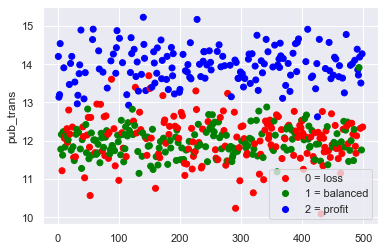

In [13]:
classes = ["0 = loss", "1 = balanced", "2 = profit"]
colors = ["red", "green", "blue"]
scatter  = plt.scatter(range(1,500), x[:,0].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors) )
plt.ylabel(features_names[0])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show

We observe a clustering of the data with respect to its classes, which we color-coded by RBG. We conclude that the _pub_trans_ feature is relevant.

<function matplotlib.pyplot.show(*args, **kw)>

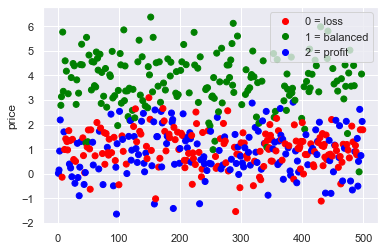

In [14]:
plt.scatter(range(1,500), x[:,1].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel(features_names[1])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show

We observe a clustering of the data with respect to its classes, which we color-coded by RBG. We conclude that the _price_ feature is relevant. This also makes intuitive sense, that the price will play a role in the success of the companies sales.

_Note: Since the data is artificially generated, of course a negative price makes no sense._

<function matplotlib.pyplot.show(*args, **kw)>

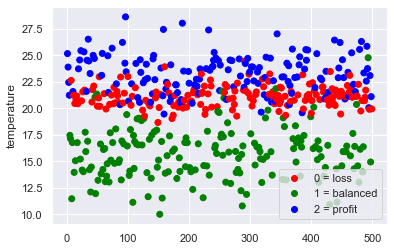

In [15]:
plt.scatter(range(1,500), x[:,2].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel(features_names[2])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show

We observe a clustering of the data with respect to its classes, which we color-coded by RBG. We conclude that the _temperature_ feature is relevant. This also makes intuitive sense, that the temperature might determine how often people are outside and hence use an E-Scooter, which translates to a companies success in sales. For example: One might not want to start an E-Scooter company in Siberia.

_Note: The data is artificial, the most loss seems to be made at around 20-22.5 degrees Celsius. Fair and rather cold weather (i.e. below 17.5 degrees Celsius) still makes balanced profit._

<function matplotlib.pyplot.show(*args, **kw)>

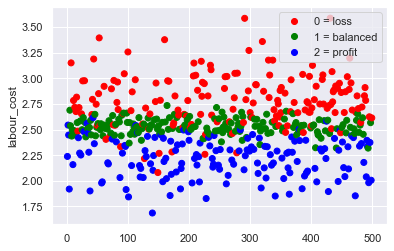

In [16]:
plt.scatter(range(1,500), x[:,9].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel(features_names[9])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show

We observe a clustering of the data with respect to its classes, which we color-coded by RBG. We conclude that the _labour_cost_ feature is relevant. This also makes intuitive sense, that the labour cost plays a role in the companies success. If the labour costs are low, the company is more likely to make a profit than with high labour costs, this is also reflected in the graph above.

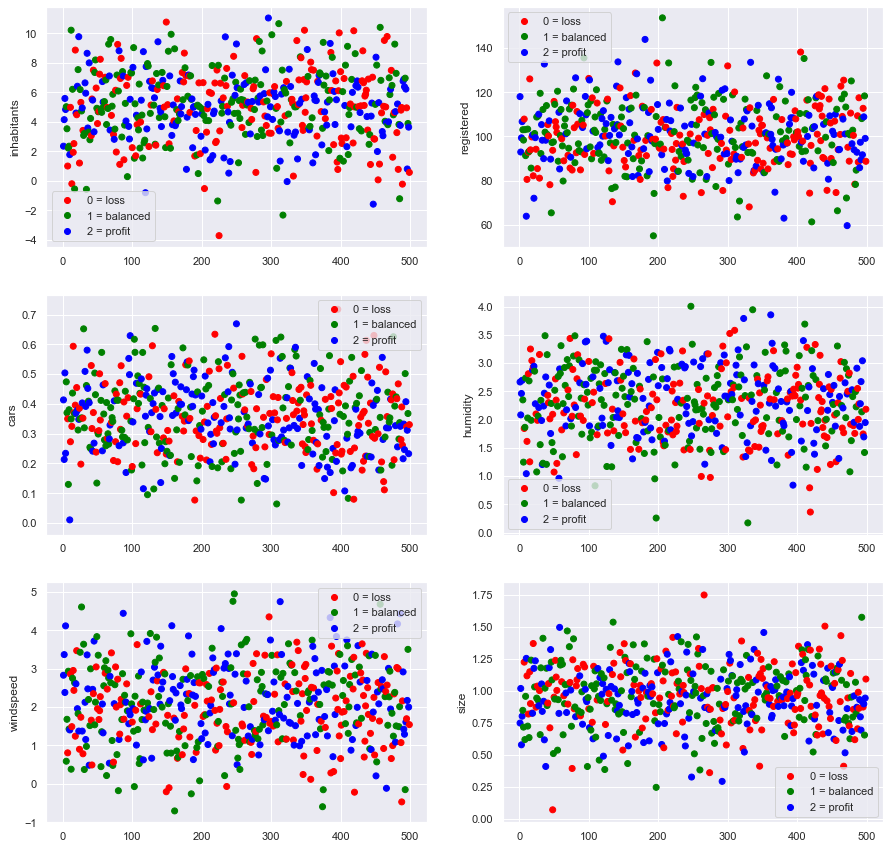

In [65]:
plt.subplots(3,2, figsize=(15,15))
plt.subplot(321)
plt.scatter(range(1,500), x[:,3].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel(features_names[3])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.subplot(322)
plt.scatter(range(1,500), x[:,4].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel(features_names[4])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.subplot(323)
plt.scatter(range(1,500), x[:,8].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel(features_names[8])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.subplot(324)
plt.scatter(range(1,500), x[:,10].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel(features_names[10])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.subplot(325)
plt.scatter(range(1,500), x[:,11].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel(features_names[11])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.subplot(326)
plt.scatter(range(1,500), x[:,12].astype(np.float), c=y[:,0].astype(np.float),  cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel(features_names[12])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

The plots above show a much more _chaotic_ behaviour of the data. There is no apparent relationship between the classes and the features. For now we shall consider them as _rather irrelevant_.

We still need to discuss whether the feature 'country' is relevant or not. We shall do this by the means of counting:

In [126]:
def counting(string):
    count_loss = 0
    count_balanced = 0
    count_profit = 0
    for i in range(len(x[:,1])):
        if (x[i,5] == string and y[i] == '0'):
            count_loss = count_loss +1
        if (x[i,5] == string and y[i] == '1'):
            count_balanced = count_balanced +1
        if (x[i,5] == string and y[i] == '2'):
            count_profit = count_profit +1
    print(string, "has:", count_loss, "instances of loss", count_balanced, "instances of balanced and", count_profit, "instances of profit")

counting("Germany")
counting("Switzerland")
counting("Austria")

Germany has: 54 instances of loss 56 instances of balanced and 57 instances of profit
Switzerland has: 55 instances of loss 58 instances of balanced and 49 instances of profit
Austria has: 59 instances of loss 62 instances of balanced and 49 instances of profit


Our analysis suggest that the country feature is also irrelevant as the instances of loss/balance/profit is evenly spread among the three countries. This makes intuitive sense: If a E-Scooter company is successful in one of the three neighbour countries Austria, Germany, Switzerland then it should also be successful in the other two. 

On top of the visual (statistical) analysis we've carried out so far, we shall incorporate an _f-test_ in order to further see which of the numerical features are relevant or not:

In [ ]:
## The f-test
filter = SelectKBest(score_func=f_classif, k="all")
mask = np.all(np.isnan(x) , axis=1)
x_no_na = x[~mask]
y_no_na = y
fit = filter.fit(x_no_na, y_no_na)
print(pd.DataFrame({"Feature": x_no_na.columns, "Score": fit.scores_}))

print("-----------------------------------------")


Evidently, not all features are relevant and we might as well _'forget'_ about them. We recall our features and mark them as relevant respectively irrelevant according to our observations above:

		pub_trans: public transport index  (relevant)
		price: price to rent per km (relevant)
		temperature: average tempereture during summer (relevant)
		inhabitants: number of inhabitants (irrelevant)
		registered: number of registered users in thousand (irrelevant)
		country: country (irrelevant)
		id: internal dataset code (irrelevant)
		nr_counterparts: nr_counterparts (irrelevant)
		cars: number of cars per inhabitant (irrelevant)
		labour_cost: average labour cost in thousand per month (relevant)
		humidity: absolute humidity in g/m3 (relevant) [maybe only a slight relevance]
		windspeed: average wind speed in km/h (relevant) [maybe only a slight relevance]
		size: size of city center in km2 (irrelevant)
		class: profitability (0 = loss, 1 = balanced, 2 = profit) <--- LABEL TO PREDICT !!!

In accordance with our observations, we limit ourselves to the following features:

In [127]:
x = x[:, [0, 1, 2, 9, 10, 11]]
features_names = features_names[[0,1,2,9,10,11]]

In [128]:
print("New features: \n", features_names)

New features: 
 ['pub_trans' 'price' 'temperature' 'labour_cost' 'humidity' 'windspeed']


And we try to convert all data to type float, so we can work with "real" numbers.

In [46]:
x = x.astype(np.float)
y = y.astype(np.float)

Luckily, the conversion works and we see that there is no missing data (NaN data).

## Shuffling and data splitting

We know that usually datapoints in a sample are not realizations of a perfectly _i.i.d. sequence of random variables_. Instead, the sample might be generated in such a way that the datapoints have some degree of time dependence without us noticing, or they might be correlated in some other way among each other. Generally speaking, we might not want to _trust_ the data as it is distributed to us, since we do not know in what way it was gathered (dependencies and so on).

Moreover, some algorithms may depend on the order of the datapoints in the sample.

In order to reduce these efffects as much as possible,it is always a good idea to __shuffle__ the datapoints before usage.

In [84]:
np.random.seed(seed=1500)


def shuffle(x, y):
    z = np.hstack((x, y))
    np.random.shuffle(z)
    return np.hsplit(z, [x.shape[1]])

In [69]:
x, y = shuffle(x,y)

In [83]:
print(x.shape)

(499, 6)


## Train and test splitting

To obtain a result of how good our model will be we cannot plainly use the empirical error obtained on the training dataset. This error is biased as we trained the model in such a way as to minimize it!

Instead, one typically would like to compute the empirical error on new, previously __unseen__ data to obtain a better estimate of how good the model describes reality. These "new, previously unseen" data __must be set aside from the beginning and separated from the training dataset__ into a test dataset.

The test dataset __will not be used for training__ and we will __use it only at the end__, in order to come up with an estimate of how good our model is.

The process of evaluating the prediction error of our model using the empirical error on the test dataset is called testing. As a rule of thumb around 20% of your total data should be hold back for testing in the end. 

Lets now make code out of this:

In [86]:
def splitting(x, y, test_size=0.2): 
    # Splitting function with a standard size of 20% for the test dataset
    # It takes as arguments the "datavectors" x and y and returns  4 vectors, x_train, x_test, y_train, y_test.
    n = x.shape[0]
    train_size = int(n * (1 - test_size))
    return x[:train_size, ], x[train_size:, ], y[:train_size, ], y[train_size:, ]

x_train, x_test, y_train, y_test = splitting(x, y)